In [1]:
import numpy as np

from PIL import Image, ImageFilter
from matplotlib import pylab as pylab
from matplotlib import pyplot as plt

from scipy.signal.windows import kaiser_bessel_derived as kbd

from mdctn import mdct, imdct

# %matplotlib inline
pylab.rcParams['figure.figsize'] = (8, 8)

from pathlib import Path

image = 'earth-64'
experiment = 'mdct_nc'

output = Path('outputs') / image

output.mkdir(exist_ok=True, parents=True)

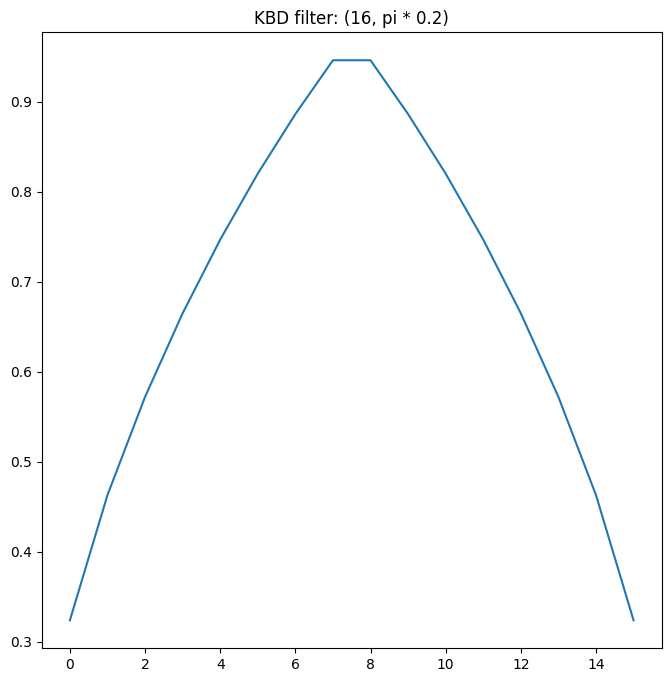

In [2]:

N=16

dct_type = 4
dct_norm = 'ortho'
kbd_alpha = 4.0
kbd_alpha = 0.2

wfltr = kbd(N, np.pi * kbd_alpha) # upto 709

plt.figure()
plt.plot(wfltr)
plt.title(f"KBD filter: (16, pi * {kbd_alpha})")

plt.savefig(f'{output}/kbd.png')

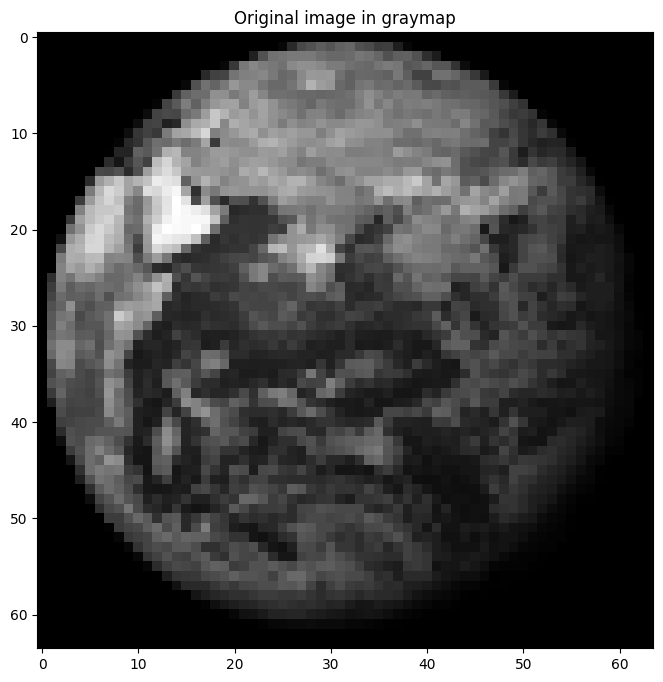

In [3]:
y, cb, cr = Image.open(f'../../images/{image}.png').convert('YCbCr').split()

im = np.array(y)
im = im[:im.shape[0] - im.shape[0]%8, :im.shape[1] - im.shape[1]%8]

im = im.astype(np.int64)

plt.figure()
plt.imshow(im, cmap='gray')
plt.title("Original image in graymap")

plt.imsave(f'{output}/original.png', im, cmap='gray')

In [4]:
quant_table_1 = np.ones(64)

quant_table_2 = [
    1,     1, 10000, 10000, 10000, 10000, 10000, 10000,
    1, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
]

quant_table_5 = [
    1,     1,     1,     1,     1, 10000, 10000, 10000,
    1,     1,     1,     1, 10000, 10000, 10000, 10000,
    1,     1,     1, 10000, 10000, 10000, 10000, 10000,
    1,     1, 10000, 10000, 10000, 10000, 10000, 10000,
    1, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
]

quant_table_11 = [
    1,     1,     1,     1,     1,     1,     1,     1,
    1,     1,     1,     1,     1,     1,     1,     1,
    1,     1,     1,     1,     1,     1,     1,     1,
    1,     1,     1,     1,     1,     1,     1,     1,
    1,     1,     1,     1,     1,     1,     1, 10000,
    1,     1,     1,     1,     1,     1, 10000, 10000,
    1,     1,     1,     1,     1, 10000, 10000, 10000,
    1,     1,     1,     1, 10000, 10000, 10000, 10000,
]

quant_table_5 = [
    1,     1,     1,     1,     1, 10000, 10000, 10000,
    1,     1,     1,     1, 10000, 10000, 10000, 10000,
    1,     1,     1, 10000, 10000, 10000, 10000, 10000,
    1,     1, 10000, 10000, 10000, 10000, 10000, 10000,
    1, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000,     1,
10000, 10000, 10000, 10000, 10000, 10000,     1, 10000,
10000, 10000, 10000, 10000, 10000,     1, 10000, 10000,
]

qtable = quant_table_2

In [5]:
def process(im, qtable):
    dct = np.zeros_like(im, dtype=np.float64)

    im -= 128

    for i in range(im.shape[0]):
        dct[i] = mdct(im[i], N, wfltr, type=dct_type, norm=dct_norm, orthogonalize=True)

    for i in range(dct.shape[1]):
        dct[:, i] = mdct(dct[:, i], N, wfltr, type=dct_type, norm=dct_norm, orthogonalize=True)
    
    for i in np.r_[:dct.shape[0]:8]:
        for j in np.r_[:dct.shape[1]:8]:
            dct[i:(i+8), j:(j+8)] = (np.rint(dct[i:(i+8), j:(j+8)].ravel() / qtable) * qtable).reshape((8, 8))
        
    im_rec = np.zeros_like(im)

    for i in range(dct.shape[1]):
        dct[:, i] = imdct(dct[:, i], N, wfltr, type=dct_type, norm=dct_norm, orthogonalize=True)

    for i in range(im.shape[0]):
        im_rec[i] = imdct(dct[i], N, wfltr, type=dct_type, norm=dct_norm, orthogonalize=True)

    im += 128
    im_rec += 128

    return im_rec.clip(0, 255).astype(np.uint8)

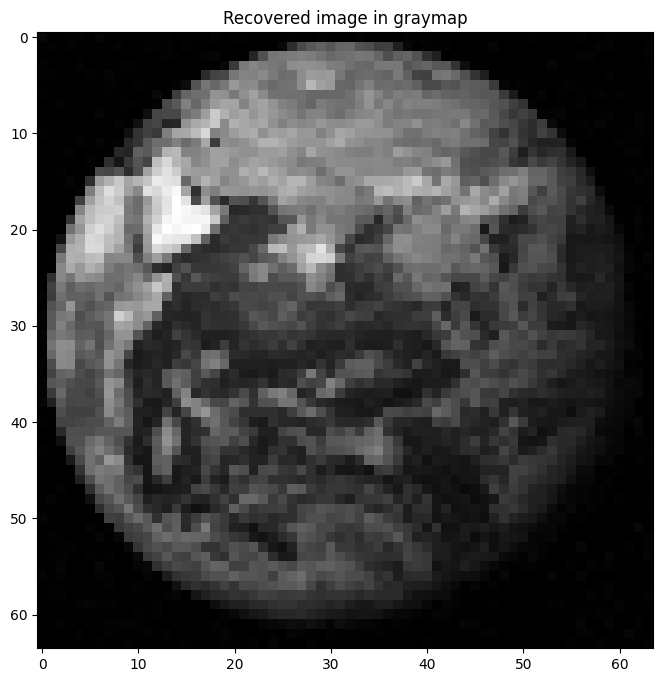

In [6]:
im_rec = process(im, qtable)

plt.figure()
plt.imshow(im_rec, cmap='gray')
plt.title("Recovered image in graymap")

plt.imsave(f'{output}/recovered.png', im_rec, cmap='gray')

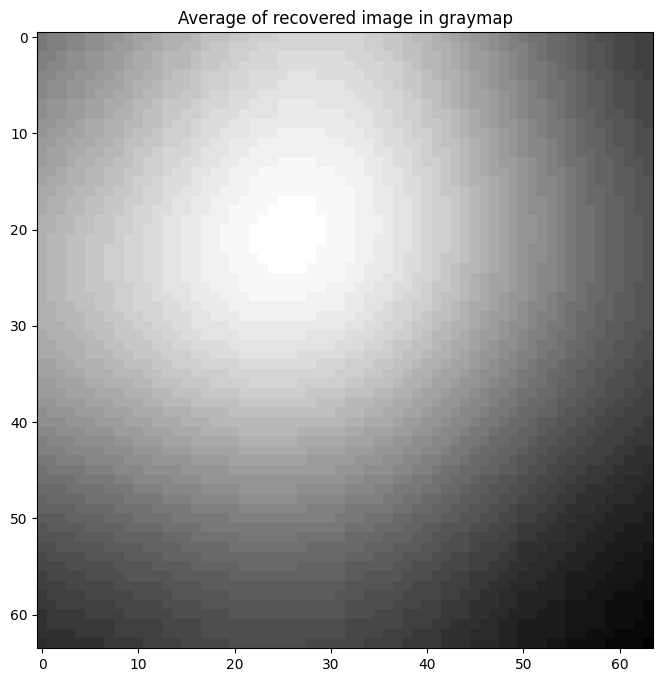

In [7]:
# im_avg = np.zeros_like(im_rec)

# for i in np.r_[:im.shape[0]:8]:
#     for j in np.r_[:im.shape[1]:8]:
#         im_avg[i:(i+8), j:(j+8)] = im_rec[i:(i+8), j:(j+8)].mean()

im_avg = np.array(Image.fromarray(im_rec, 'L').filter(ImageFilter.GaussianBlur(radius=16)))

plt.figure()
plt.imshow(im_avg, cmap='gray')
plt.title("Average of recovered image in graymap")

plt.imsave(f'{output}/average.png', im_avg, cmap='gray')

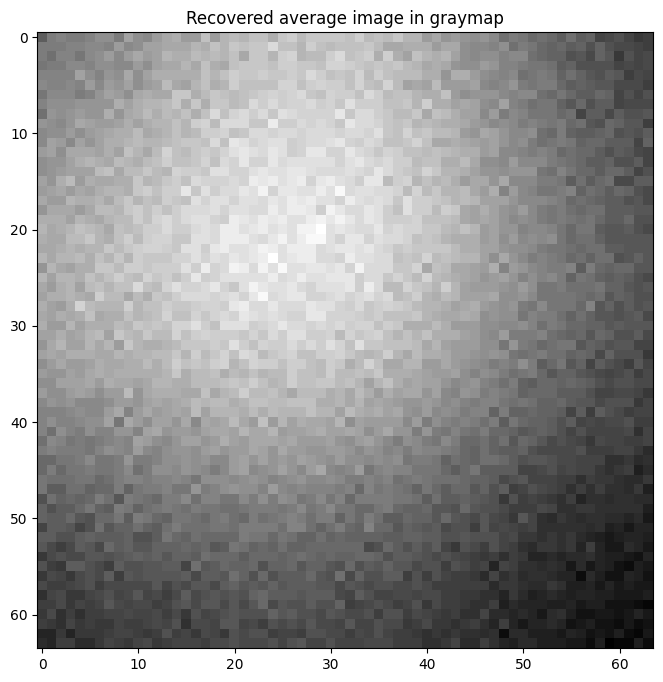

In [8]:
im_avg_rec = process(im_avg, qtable)


plt.figure()
plt.imshow(im_avg_rec, cmap='gray')
plt.title("Recovered average image in graymap")

plt.imsave(f'{output}/recovered_average.png', im_rec, cmap='gray')

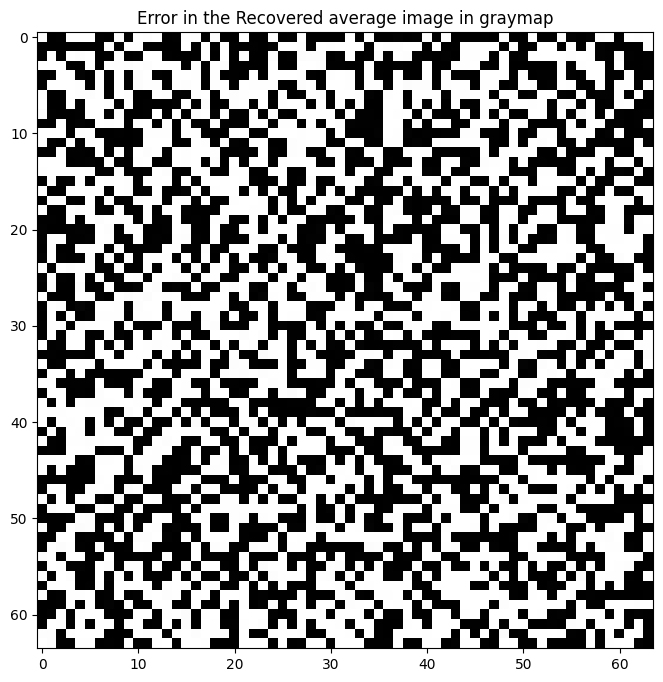

In [9]:
im_avg_rec_err = im_avg_rec - im_avg

plt.figure()
plt.imshow(im_avg_rec_err, cmap='gray')
plt.title("Error in the Recovered average image in graymap")

plt.imsave(f'{output}/error_recovered_average.png', im_avg_rec_err, cmap='gray')

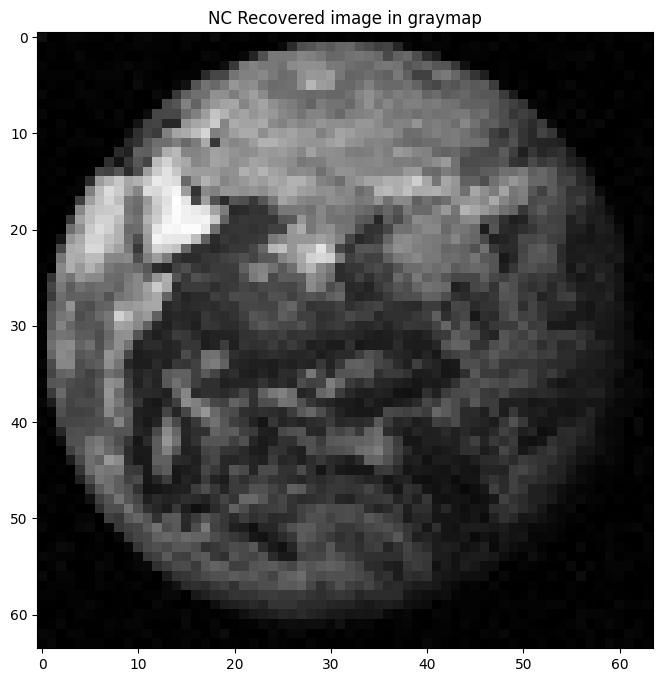

In [10]:
im_nc = im_rec - im_avg_rec_err

im_nc[im_nc > 220] = 0

plt.figure()
plt.imshow(im_nc, cmap='gray')
plt.title("NC Recovered image in graymap")

plt.imsave(f'{output}/rec_nc.png', im_nc, cmap='gray')

In [11]:
im_nc

array([[8, 0, 0, ..., 2, 2, 1],
       [0, 2, 1, ..., 0, 0, 3],
       [1, 2, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 4, ..., 0, 3, 1],
       [4, 3, 0, ..., 4, 3, 0],
       [2, 4, 0, ..., 3, 0, 2]], dtype=uint8)